In [1]:
import importlib
import covidStream

from psaw import PushshiftAPI
import oauth, tweepy, praw
from youtube_api import YouTubeDataAPI

from wordcloud import WordCloud, STOPWORDS 
import json
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import datetime as dt
import time, functools, operator
from collections import Counter

from bs4 import BeautifulSoup
from requests import get

import networkx as nx

In [2]:
with open("Credentials/redditCredentials.json", "r") as redditFile:
    redditCredentials = json.load(redditFile)

In [3]:
reddit = praw.Reddit(client_id=redditCredentials['client_id'], \
                     client_secret=redditCredentials['client_secret'], \
                     user_agent='test', \
                     username=redditCredentials['username'], \
                     password=redditCredentials['password'])

psawAPI = PushshiftAPI(reddit)

In [4]:
with open("Credentials/twitterCredentials.json", "r") as twitterFile:
    twitterCredentials = json.load(twitterFile)

In [5]:
auth = tweepy.OAuthHandler(twitterCredentials['consumer_key'], twitterCredentials['consumer_secret'])
auth.set_access_token(twitterCredentials['access_key'], twitterCredentials['access_secret'])
twitterAPI = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [ ]:
submissionCH = list(psawAPI.search_submissions(subreddit='Switzerland',
                                               q='Megathread Coronavirus',
                                               filter=['url','author', 'title', 'created_utc', 'comments']))

In [78]:
for submission in submissionCH:
    submission.comments.replace_more(limit=None)
    commentsCH.extend(submission.comments.list())
    print(submission.title, len(commentsCH))

[Megathread] Coronavirus in Switzerland and elsewhere, Part 6 753
[Megathread] Coronavirus in Switzerland and elsewhere, Part 5 - NEW RULES 1893
[Megathread] Coronavirus in Switzerland and elsewhere, Part 4 2617
[Megathread] Coronavirus in Switzerland and elsewhere, Part 3 4014
[Megathread] Coronavirus in Switzerland and elsewhere Part 2: Self-responsibility boogaloo 5332
[Megathread] Coronavirus in Switzerland and elsewhere 6643


In [173]:
import pickle

with open("commentsCH.txt", "wb") as chFile:   #Pickling
    pickle.dump(commentsCH, chFile)

In [8]:
import pickle

with open("Switzerland Data/commentsCH.txt", "rb") as chFile:   # Unpickling
    commentsCH = pickle.load(chFile)

In [9]:
createdDates = [dt.datetime.strptime(time.ctime(comment.created_utc), '%a %b %d %H:%M:%S %Y').date() for comment in commentsCH]
datesStringList = [date.strftime('%m-%d') for date in createdDates]

datesColumns = list(set(datesStringList))
datesColumns.sort()

datesCount = Counter(datesStringList)
datesDict = [{'Date': date, '# Comments': datesCount[date]} for date in datesColumns]
datesDF = pd.DataFrame(datesDict).sort_values(by='Date').set_index('Date')

Text(0, 0.5, 'Comment Count')

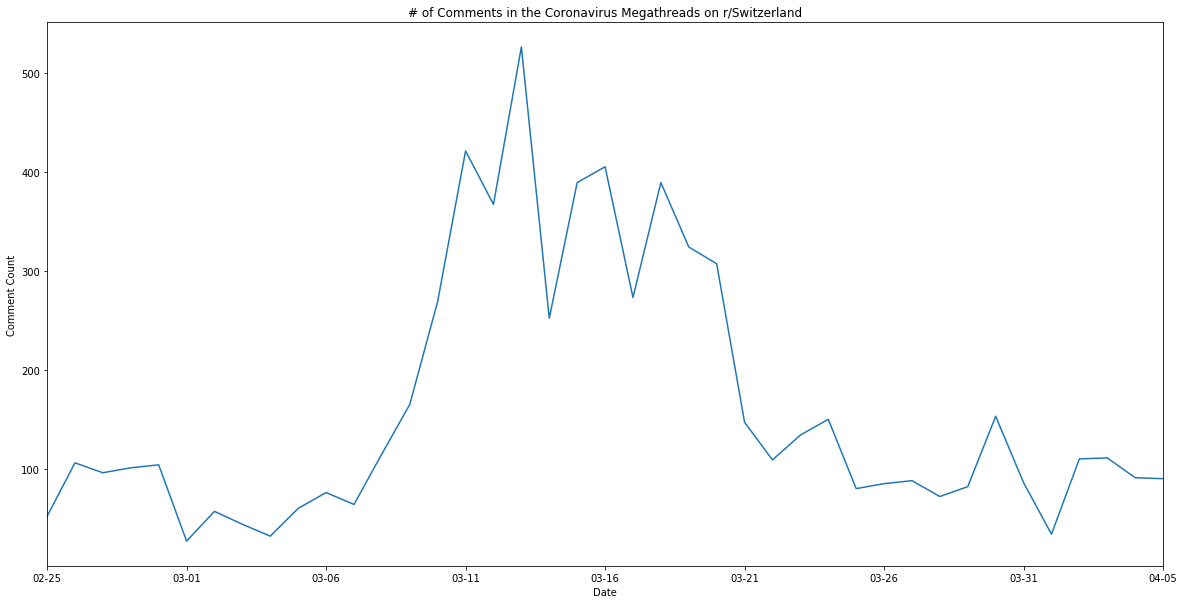

In [10]:
ax = datesDF.plot.line(figsize=(20, 10))
ax.get_legend().remove()
ax.title.set_text('# of Comments in the Coronavirus Megathreads on r/Switzerland')
ax.set_xlabel('Date')
ax.set_ylabel('Comment Count')

### Analysis of the links shared on the Coronavirus Megathreads

In [14]:
urlCH = [{'date': dt.datetime.strptime(time.ctime(comment.created_utc), '%a %b %d %H:%M:%S %Y').date(),
          'link': re.sub(r'(.*://)?([^/?]+).*', '\g<1>\g<2>', re.search("(?P<url>https?://[^\s]+)", comment.body).group("url")).split('//')[-1]}
          for comment in commentsCH if re.search("(?P<url>https?://[^\s]+)", comment.body) is not None]

In [21]:
urlDF = pd.DataFrame(urlCH).sort_values(by='date').reset_index(drop=True)

In [171]:
urlDF.to_csv('urlSwitzerland.csv')

In [28]:
import operator

linkCount = dict(Counter(list(urlDF.link.values)))
linkCountSorted = sorted(linkCount.items(), key=operator.itemgetter(1), reverse=True)

In [63]:
linkDict = [{'source': link[0], 'count': link[1]} for link in linkCountSorted[0:15]]

In [64]:
linkDF = pd.DataFrame(linkDict)
linkDF

source  count
0             twitter.com     53
1         www.youtube.com     44
2          www.reddit.com     34
3        www.bag.admin.ch     34
4               imgur.com     29
5   www.worldometers.info     27
6              www.srf.ch     25
7                youtu.be     16
8        www.swissinfo.ch     14
9    www.tagesanzeiger.ch     14
10             www.nzz.ch     13
11         old.reddit.com     10
12             www.rts.ch     10
13   www.ncbi.nlm.nih.gov      9
14              www.bs.ch      8

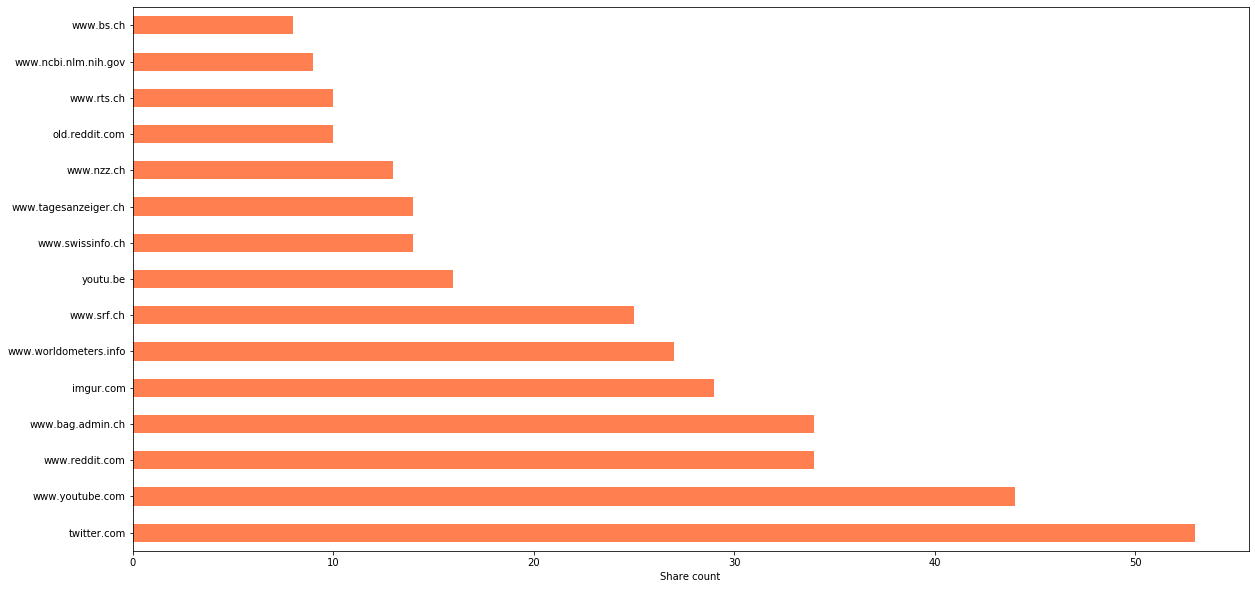

In [66]:
ax = linkDF.plot(kind='barh', figsize=(20, 10), legend=False, color='coral')
ax.set_yticklabels(linkDF.source)
ax.set_xlabel("Share count")
fig = ax.get_figure()
fig.savefig('Switzerland Data/sourceHist.png')

In [172]:
with open('switzerlandLink.txt', 'w') as file:
     file.write(json.dumps(linkCount))

In [16]:
linkRootsList = [url['link'] for url in urlCH]

(array([317.,  60.,  62.,  71.,  60.,  48.,  41.,  38.,  35.,  28.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

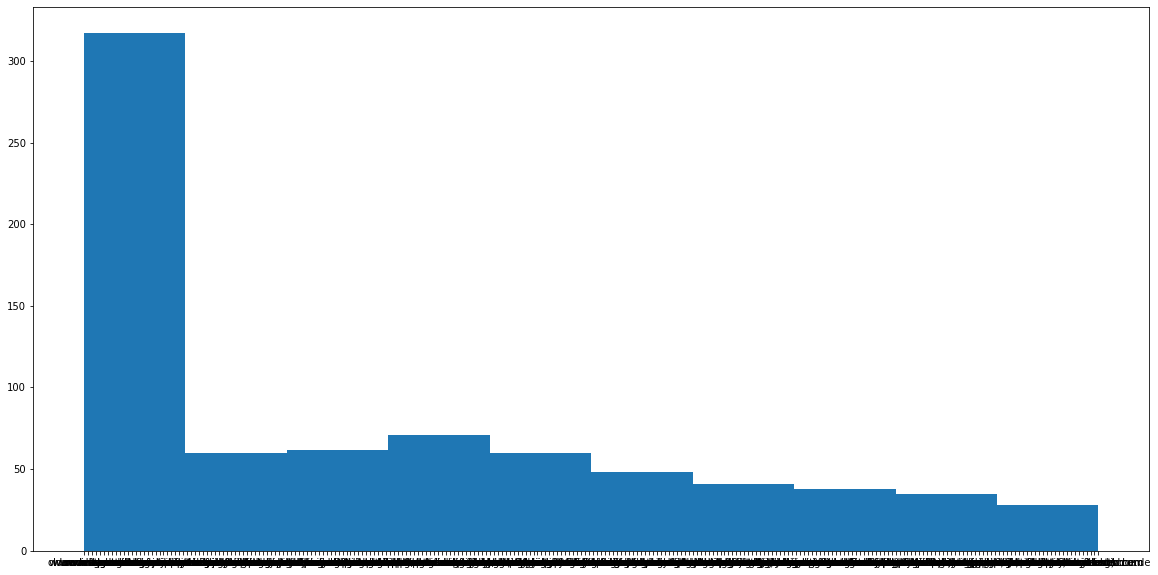

In [19]:
plt.figure(figsize=(20,10))
plt.hist(linkRootsList)

### Detection of Swiss personalities in the comments

In [101]:
bersetComments = [comment for comment in commentsCH if 'berset' in comment.body.lower()]
kochComments = [comment for comment in commentsCH if 'koch' in comment.body.lower()]
sommarugaComments = [comment for comment in commentsCH if 'sommaruga' in comment.body.lower()]

### Retrieval of the Twitter accounts linked by r/Switzerland users

In [11]:
linkList = [re.search("(?P<url>https?://[^\s]+)", comment.body).group("url") for comment in commentsCH 
               if re.search("(?P<url>https?://[^\s]+)", comment.body) is not None]
twitterList = [link for link in linkList if 'twitter.com' in link]

In [138]:
twitterUsernameList = [link.split('com/')[1].split('/')[0].replace('\\', '') for link in twitterList]

In [156]:
statusList = [link.split('status/')[1][:19] for link in twitterList if len(link.split('status/')) > 1]

In [153]:
statusIndex = []
for status in statusList:
    for index, char in enumerate(status):
        if not char.isdigit():
            statusIndex.append(index)
            break

In [165]:
tweetList = []
for status in statusList:
    try:
        tweet = twitterAPI.get_status(status, tweet_mode='extended')
        tweetUser = twitterAPI.get_user(tweet.user.screen_name)
        tweetAuthor = tweetUser.screen_name
        tweetUsername = tweetUser.name
        tweetFollowers = tweetUser.followers_count
        tweetAccountAge = tweetUser.created_at
        try:
            accountDate = tweetAccountAge.strftime("%Y-%m-%d")
            accountTime = tweetAccountAge.strftime("%H:%M:%S")
        except ValueError:
            accountDate = 'Unknown'
            accountTime = 'Unknown'
            pass

        tweetText = tweet.full_text
        tweetDateTime = tweet.created_at

        try:
            tweetDate = tweetDateTime.strftime("%Y-%m-%d")
            tweetTime = tweetDateTime.strftime("%H:%M:%S")
        except ValueError:
            tweetDate = 'Unknown'
            tweetTime = 'Unknown'
            pass
        
        tweetList.append({'author': tweetAuthor, 'username': tweetUsername, 'followers': tweetFollowers,
                          'accountDate': accountDate, 'accountTime': accountTime, 'tweetDate': tweetDate, 'tweetTime': tweetTime,
                          'text': tweetText})

    except tweepy.TweepError:
        pass

In [166]:
tweetDF = pd.DataFrame(tweetList)
tweetDF.to_csv('twitterSwitzerland.csv')

### r/China_Flu tweets retrieval

In [6]:
chinaSubmissions = list(psawAPI.search_submissions(subreddit='China_Flu', filter=['author', 'created_at', 'url', 'upvote_ratio', 'score', 'title']))

/home/aminmekacher/.local/lib/python3.7/site-packages/psaw/PushshiftAPI.py:244: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)


In [28]:
twitterSubs = [submission for submission in chinaSubmissions if any(twitterLink in submission.url for twitterLink in ['//twitter.com', '//mobile.twitter.com'])]

In [ ]:
importlab.reload(covidStream)
covidStream.china_flu_scrapping(twitterSubs)